In [215]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
import numpy as np
from adjustText import adjust_text
pd.options.display.float_format = '{:.2f}'.format

# Data Loads

In [216]:
## state COLI
state_abbreviations = {
    'Alabama': 'al',
    'Alaska': 'ak',
    'Arizona': 'az',
    'Arkansas': 'ar',
    'California': 'ca',
    'Colorado': 'co',
    'Connecticut': 'ct',
    'Delaware': 'de',
    'Florida': 'fl',
    'Georgia': 'ga',
    'Hawaii': 'hi',
    'Idaho': 'id',
    'Illinois': 'il',
    'Indiana': 'in',
    'Iowa': 'ia',
    'Kansas': 'ks',
    'Kentucky': 'ky',
    'Louisiana': 'la',
    'Maine': 'me',
    'Maryland': 'md',
    'Massachusetts': 'ma',
    'Michigan': 'mi',
    'Minnesota': 'mn',
    'Mississippi': 'ms',
    'Missouri': 'mo',
    'Montana': 'mt',
    'Nebraska': 'ne',
    'Nevada': 'nv',
    'New Hampshire': 'nh',
    'New Jersey': 'nj',
    'New Mexico': 'nm',
    'New York': 'ny',
    'North Carolina': 'nc',
    'North Dakota': 'nd',
    'Ohio': 'oh',
    'Oklahoma': 'ok',
    'Oregon': 'or',
    'Pennsylvania': 'pa',
    'Rhode Island': 'ri',
    'South Carolina': 'sc',
    'South Dakota': 'sd',
    'Tennessee': 'tn',
    'Texas': 'tx',
    'Utah': 'ut',
    'Vermont': 'vt',
    'Virginia': 'va',
    'Washington': 'wa',
    'West Virginia': 'wv',
    'Wisconsin': 'wi',
    'Wyoming': 'wy',
    'District of Columbia': 'dc',
    'Puerto Rico': 'pr',
    'Guam': 'gu',
    'American Samoa': 'as',
    'U.S. Virgin Islands': 'vi',
    'Northern Mariana Islands': 'mp'
}

# Replace state names with their abbreviations

state_coli = pd.read_csv('data/demographic_data/world_population_review_coli.csv')

state_coli['abbrev'] = state_coli['State'].replace(state_abbreviations)



In [217]:
## city COLI

city_coli = pd.read_csv('data/demographic_data/advisorsmith_cost_of_living_index.csv')
city_coli.columns = [x.lower() for x in city_coli.columns]
city_coli['city'] = city_coli['city'].str.lower()
city_coli['state'] = city_coli['state'].str.lower()
# city_coli

In [218]:
# with open('data/spring_2023/full_df.pkl', 'rb') as file:
with open('data/summer_2024_august/full_df.pkl', 'rb') as file:
    full_df = pkl.load(file)

len(full_df)

1538840

In [220]:

full_df = full_df.drop_duplicates(subset = ['item_name', 'store_id']) # need this because the same item might be listed under multiple categories
len(full_df)

full_df['state'], full_df['city'] = zip(*full_df['location_url'].str.split('/').str[3:5])

# Aggregations

In [229]:

core_items = [
              'Supreme Taco Party Pack', 
            #   'Chicken Quesadilla', 
            #   'Cinnabon Delights® 12 Pack', 
            #   'Crunchwrap Supreme®', 
            #   'Beefy 5 Layer Burrito', 
            #   'Nacho Cheese Doritos Locos Taco', 
            #   '3 Doritos Locos Tacos Combo'
              ]

working = full_df[full_df['item_name'].isin(core_items)]
working = working[~working['state'].isin(['vt', 'me'])] # not enough data

In [227]:
# working.head()
# city_distro[city_distro['num_stores'] != 1]
# working[working['city'] == 'fort-bragg']
len(working)
len(working['state'].unique())

46

In [230]:
agg_funcs = {
    'mean': 'mean',
    'median': 'median',
    'num_stores': 'size',
    'nunique_prices': 'nunique',
    'max': 'max',
    'min': 'min',
    'sd': 'std'
}

########## in aggregate

# metric = 'median'
metric = 'mean'

state_distro = working.groupby(['state', 'item_name'])['value'].agg(**agg_funcs).sort_values(by = ['item_name', metric], ascending = False).reset_index()

city_distro = working.groupby(['city', 'state', 'item_name'])['value'].agg(**agg_funcs).sort_values(by = ['item_name', metric], ascending = False).reset_index()

item_distro = working.groupby('item_name')['value'].agg(**agg_funcs).sort_values(by = ['item_name', metric], ascending = False).reset_index()


# Cost of Living Correlations

In [258]:
def plot_regression(merged_df, x_var, y_var, hue_var='state', title_prefix='', custom_title = None, label_top_n=10):
    """
    Plots a linear regression scatter plot with a regression line, R-squared, and RMSE.
    
    Parameters:
    merged_df (pd.DataFrame): The dataframe containing the data to plot.
    x_var (str): The name of the column to use as the independent variable (X-axis).
    y_var (str): The name of the column to use as the dependent variable (Y-axis).
    hue_var (str): The name of the column to use for coloring the points (default is 'state').
    title_prefix (str): A string to prefix the title of the plot with.
    label_top_n (int): The number of top points to label (default is 10).
    
    Returns:
    None
    """
    # Perform the regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df[x_var], merged_df[y_var])
    
    # Calculate predicted values
    y_pred = intercept + slope * merged_df[x_var]
    
    # Calculate R-squared and RMSE
    r_squared = r_value**2
    rmse = np.sqrt(np.mean((y_pred - merged_df[y_var])**2))
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=merged_df[x_var], y=merged_df[y_var], hue=merged_df[hue_var], palette="viridis", s=100, legend=False)
    
    # Plot the regression line
    plt.plot(merged_df[x_var], y_pred, color='red', label=f'Regression Line\ny = ${intercept:.2f} + ${slope:.2f}x')
    
    # Annotate only a subset of points to avoid clutter
    if label_top_n > 0:
        top_n_df = merged_df.nlargest(label_top_n, y_var)
        texts = []
        for i in range(len(top_n_df)):
            texts.append(plt.text(top_n_df[x_var].iloc[i], top_n_df[y_var].iloc[i], top_n_df[hue_var].iloc[i], fontsize=9))
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    
    # Add R-squared and RMSE to the plot
    plt.text(0.79, 0.15, f'correlation = {r_value:.2f}\nRMSE = ${rmse:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    
    # Add labels and title
    # plt.xlabel('x_var')
    plt.xlabel('Cost of Living Index')
    # plt.ylabel(f'{y_var} ($)')
    plt.ylabel('mean ($)')
    # Use custom title if provided, otherwise construct the title
    if custom_title:
        plt.title(custom_title)
    else:
        plt.title(f'{title_prefix}{y_var} against {x_var}')
    plt.legend()
    
    # Show the plot
    plt.show()

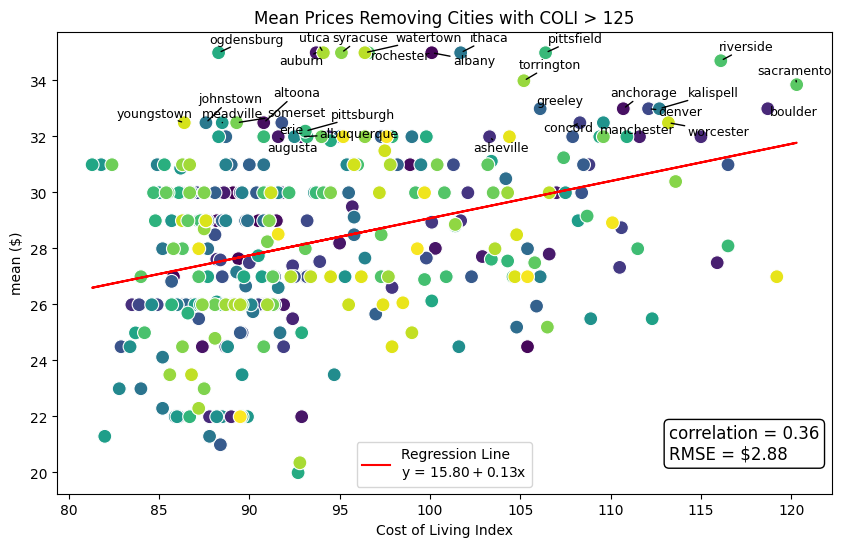

In [265]:
merged_city = city_coli.merge(city_distro, how = 'inner', on = ['city', 'state'])
# plot_regression(merged_city, 'cost of living index', 'mean', hue_var = 'city', title_prefix='Taco Bell Prices: ', custom_title = 'Mean Supreme Taco Party Pack Prices Against Cost of Living Index', label_top_n=30)
plot_regression(merged_city[merged_city['cost of living index'] < 121], 'cost of living index', 'mean', hue_var = 'city', title_prefix='Taco Bell Prices removing 121: ', custom_title = 'Mean Prices Removing Cities with COLI > 125', label_top_n=30)
# plot_regression(merged_city[merged_city['cost of living index'] >= 121], 'cost of living index', 'mean', hue_var = 'city', title_prefix='Taco Bell Prices removing anything above COLI =121: ', label_top_n=0)

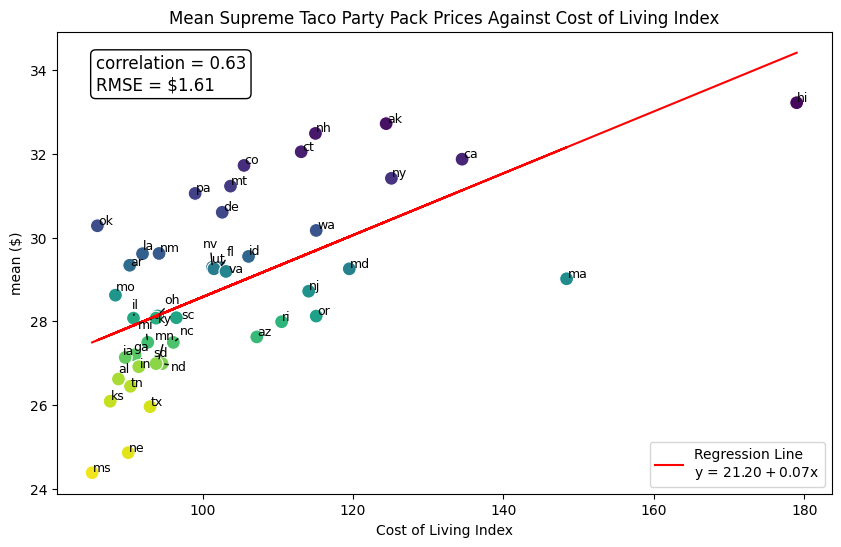

In [235]:
merged_state = state_distro.merge(state_coli, how = 'left', left_on = 'state', right_on = 'abbrev')
plot_regression(merged_state, 'Cost of Living Index', 'mean', title_prefix='Taco Bell Prices: ', custom_title = 'Mean Supreme Taco Party Pack Prices Against Cost of Living Index' , label_top_n=50)
# plot_regression(merged_state[merged_state['state'] !='hi'], 'Cost of Living Index', 'mean', title_prefix='Taco Bell Prices: ', label_top_n=50)
# plot_regression(merged_state[merged_state['state'] !='vt'], 'Cost of Living Index', 'mean', title_prefix='Taco Bell Prices: ', label_top_n=50)

# Overpaying Analysis

In [266]:
merged_city['mean_coli'] = merged_city['cost of living index'].mean()
merged_city['pct_deviation_coli'] = (merged_city['cost of living index'] / merged_city['cost of living index'].mean()) - 1
merged_city['pct_deviation_price'] = (merged_city['mean'] / merged_city['mean'].mean()) - 1

# plot_regression(merged_city, 'pct_deviation_coli', 'pct_deviation_price', title_prefix='Taco Bell Prices: ', label_top_n=50)

merged_city['overpaying_delta'] = merged_city['pct_deviation_price'] - merged_city['pct_deviation_coli']
merged_city['overpaying_delta'].describe()

count   352.00
mean      0.00
std       0.13
min      -0.53
25%      -0.07
50%      -0.00
75%       0.09
max       0.31
Name: overpaying_delta, dtype: float64

In [267]:
merged_state['mean_coli'] = merged_state['Cost of Living Index'].mean()
merged_state['pct_deviation_coli'] = (merged_state['Cost of Living Index'] / merged_state['Cost of Living Index'].mean()) - 1
merged_state['pct_deviation_price'] = (merged_state['mean'] / merged_state['mean'].mean()) - 1

# plot_regression(merged_state, 'pct_deviation_coli', 'pct_deviation_price', title_prefix='Taco Bell Prices: ', label_top_n=50)
merged_state['overpaying_delta'] = merged_state['pct_deviation_price'] - merged_state['pct_deviation_coli']
merged_state['overpaying_delta'].describe()

count   45.00
mean    -0.00
std      0.14
min     -0.58
25%     -0.01
50%      0.03
75%      0.07
max      0.22
Name: overpaying_delta, dtype: float64

In [324]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_bar_chart(df, x_var, y_var, title="Bar Chart", xlabel=None, ylabel=None, bar_labels = True):
    # plt.clf()
    """
    Creates a bar chart from the provided DataFrame with labels above/below each bar.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data to plot.
    x_var (str): The name of the column to use as the x-axis variable.
    y_var (str): The name of the column to use as the y-axis variable.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis. If None, x_var is used.
    ylabel (str): The label for the y-axis. If None, y_var is used.
    
    Returns:
    None
    """
    # Sorting the DataFrame by the absolute value of y_var
    df['abs'] = np.abs(df[y_var])
    df = df.sort_values(by='abs', ascending=False)
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x=x_var, y=y_var, 
                    #  palette='viridis'
                     palette=['#36399a', '#ef1897', '#fee012', '#a77bca']
                     )
    
    # Adding labels to the bars
    if bar_labels:
        for p, state_label in zip(ax.patches, df[x_var]):
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., height + 0.01, state_label, ha="center")
            else:
                ax.text(p.get_x() + p.get_width() / 2., height - 0.04, state_label, ha="center")
        
    ax.set_xticks([])
    ax.set_xlabel('')
    plt.title(title)
    # plt.xlabel(xlabel if xlabel else x_var)
    plt.ylabel(ylabel if ylabel else y_var)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a DataFrame named `df` with columns "overpaying_delta" and "state"
# create_bar_chart(df, x_var="state", y_var="overpaying_delta", title="Overpaying Delta by State", xlabel="State", ylabel="Overpaying Delta")


In [325]:
# merged_state.sort_values(by = 'abs', ascending = False)

/var/folders/r8/1njvdjqs71vfshzknvlgyy_h0000gn/T/ipykernel_4736/1028662803.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




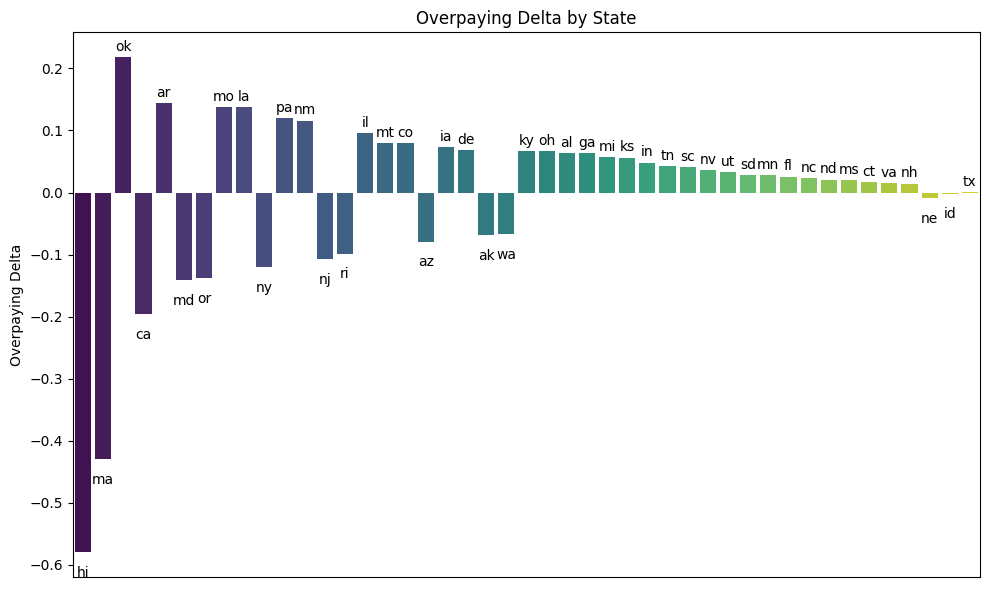

In [314]:
create_bar_chart(merged_state, x_var="state", y_var="overpaying_delta", title="Overpaying Delta by State", xlabel="State", ylabel="Overpaying Delta")

/var/folders/r8/1njvdjqs71vfshzknvlgyy_h0000gn/T/ipykernel_4736/544821214.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/r8/1njvdjqs71vfshzknvlgyy_h0000gn/T/ipykernel_4736/544821214.py:26: UserWarning:


The palette list has fewer values (4) than needed (320) and will cycle, which may produce an uninterpretable plot.



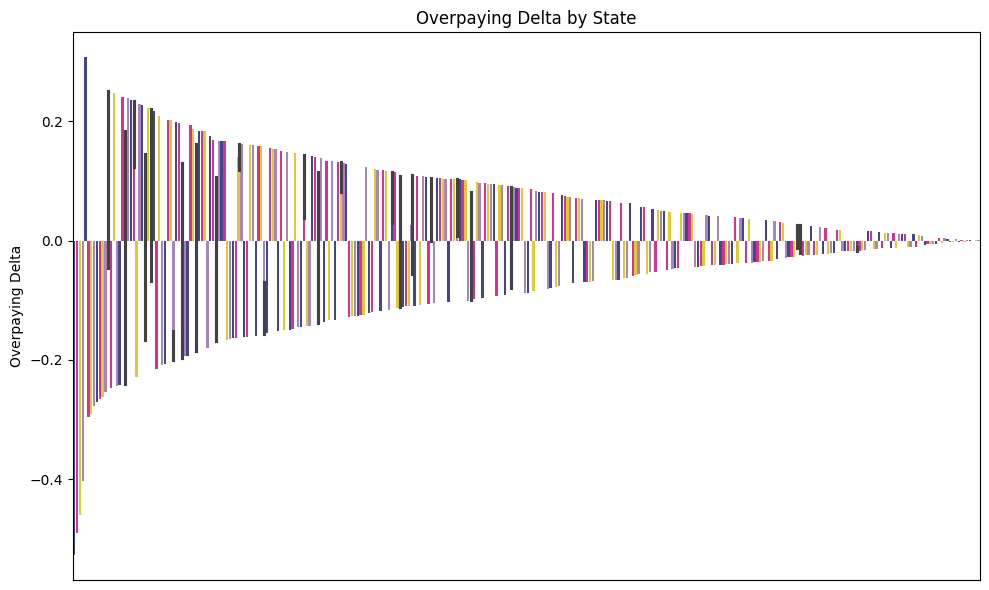

In [326]:
create_bar_chart(merged_city, x_var="city", y_var="overpaying_delta", title="Overpaying Delta by State", xlabel="State", ylabel="Overpaying Delta", bar_labels=False)

In [323]:
## histogram

merged_state[['state', 'overpaying_delta']]

graph_col = 'overpaying_delta'
nbins = 20
title = 'State Overpaying Deltas'
fig = px.histogram(merged_state, x=graph_col, nbins=nbins, title=title)
fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.show()
# sns.histplot(merged_state['overpaying_delta'], kde=False, bins=10)


In [331]:
merged_state['overpaying_delta'].describe()

count   45.00
mean    -0.00
std      0.14
min     -0.58
25%     -0.01
50%      0.03
75%      0.07
max      0.22
Name: overpaying_delta, dtype: float64

In [329]:
merged_city[['city', 'overpaying_delta']]

graph_col = 'overpaying_delta'
nbins = 50
title = 'City % Overpaying'
fig = px.histogram(merged_city, x=graph_col, nbins=nbins, title=title)
fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.show()

In [339]:
merged_city['overpaying_delta'].describe()
merged_city[merged_city['overpaying_delta'] < 0 ].sort_values(by = 'abs', ascending = False).head(30)[['city', 'state', 'overpaying_delta']]
merged_city[merged_city['overpaying_delta'] > 0 ].sort_values(by = 'abs', ascending = False).head(30)[['city', 'state', 'overpaying_delta']]

,city,state,overpaying_delta
218,ogdensburg,ny,0.31
22,auburn,ny,0.25
307,utica,ny,0.25
209,muskogee,ok,0.24
327,youngstown,oh,0.24
290,syracuse,ny,0.24
187,marion,in,0.23
273,shawnee,ok,0.23
146,johnstown,pa,0.23
315,watertown,ny,0.22


# Variations in Pricing Analysis

In [ ]:
def visualize_deviations(state_distro, bounds, graph_col = 'mean', nbins=20, title='Histogram of Mean Values by State'):
    
    # Calculate statistics
    mean_value = state_distro[graph_col].mean()
    # print(mean_value)
    # median_value = state_distro[graph_col].median()  # Uncommented for proper usage
    
    # Adjust plus_val and minus_val based on mean
    plus_val = mean_value * (1 + bounds)  # Apply the plus_val percentage to the mean
    minus_val = mean_value * (1 - bounds)  # Apply the minus_val percentage to the mean
    
    # Calculate the percentage of data within the range
    pct_data_in_range = len(state_distro[(state_distro[graph_col] >= minus_val) & (state_distro[graph_col] <= plus_val)]) / len(state_distro)
    
    # Create the histogram
    fig = px.histogram(state_distro, x=graph_col, nbins=nbins, title=title)
    # Change the x-axis label
    fig.update_xaxes(title_text='Price')
    fig.update_yaxes(title_text='Count')
    fig.update_traces(marker_color='#a77bca') # #a77bca #36399a
    # Adding black lines around each bin
    fig.update_traces(marker_line_color='black', marker_line_width=1.5)

    # Add vertical lines for the mean, plus_val, and minus_val
    fig.add_vline(x=mean_value, line=dict(color='green', dash='dash'))
    fig.add_vline(x=plus_val, line=dict(color='red', dash='dash'))
    fig.add_vline(x=minus_val, line=dict(color='purple', dash='dash'))
    
    # Add annotations for clarity
    label_pos = 1000
    ay_val = 0
    offset = 0.7
    fig.add_annotation(x=mean_value - offset, y=label_pos, text='mean', showarrow=False, arrowhead=1, ax=0, ay=ay_val)
    fig.add_annotation(x=plus_val- offset, y=label_pos, text=f"+{bounds}%", showarrow=False, arrowhead=1, ax=0, ay=ay_val)
    fig.add_annotation(x=minus_val- offset, y=label_pos, text=f"-{bounds}%", showarrow=False, arrowhead=1, ax=0, ay=ay_val)
    
    # Add annotation for the percentage of data within the range
    fig.add_annotation(
        text=f"""The mean is ${round(mean_value, 2)}<br>The lower bound is ${round(minus_val, 2)}<br>The upper bound is ${round(plus_val, 2)}<br>""",
        xref="paper", yref="paper",
        x=0, y=1,
        showarrow=False,
        font=dict(size=12),
        align="left",
        xanchor='left',
        yanchor='top'
    )
    
    # Show the figure
    fig.show()
    # {round(pct_data_in_range * 100, 1)}% of the data falls within {100*bounds}% of the mean<br>

        # text=f"""The amount of data within the bands is {round(pct_data_in_range * 100, 1)}%\n
        # The mean value is {mean_value}\n
        # The upper bound is {plus_val}\n
        # The lower bound is {minus_val}\n
        #       """,


In [ ]:
bounds = .1
visualize_deviations(state_distro, bounds, nbins=20, title='Histogram of Mean Values by State')

In [ ]:
bounds = .10
visualize_deviations(state_distro, bounds, nbins=20, title='Histogram of Mean Values by State')

In [ ]:
bounds = .15
visualize_deviations(working, bounds, graph_col = 'value', nbins=30, title = 'Distribution of Supreme Taco Party Pack Prices Across the Country')

In [ ]:
working[working['value'] == 15.99]

In [ ]:
# bounds = .15
# visualize_deviations(working[~working['state'].isin(['hi', 'ak'])], bounds, graph_col = 'value', nbins=100, title = 'all prices') 

In [ ]:
working[working['state'] == 'ms']['value'].describe()

In [ ]:
state_distro.describe()

In [ ]:
state_coli['Cost of Living Index'].describe()

In [ ]:
city_coli['cost of living index'].describe()

In [ ]:
item_distro

In [ ]:
state_distro

In [341]:
full_df['location_url'].nunique()

7177